# 1 - Import Libraries

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
import pickle
import requests
import folium
import pandas as pd
import numpy as np # library to handle data in a vectorized manner

import shapely.geometry
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import pyproj
import math

import matplotlib.pyplot as plt
import json, lxml
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup

# 2 - Extract Berlin Boroughs info

In [2]:
url = 'https://en.wikipedia.org/wiki/Boroughs_and_neighborhoods_of_Berlin'
source = requests.get(url).text
soup = BeautifulSoup(source)

table_data = soup.find('div', class_='mw-parser-output')
table = table_data.table.tbody

columns = ['Borough', 'Population', 'Area', 'Density']
data = dict({key:[]*len(columns) for key in columns})

for row in table.find_all('tr'):
    for i,column in zip(row.find_all('td'),columns):
        i = i.text
        i = i.replace('\n', '')
        data[column].append(i)

df = pd.DataFrame.from_dict(data=data)[columns]
print(df.shape)
df

(12, 4)


,Borough,Population,Area,Density
0,Charlottenburg-Wilmersdorf,"319,628",64.72,"4,878"
1,Friedrichshain-Kreuzberg,"268,225",20.16,"13,187"
2,Lichtenberg,"259,881",52.29,"4,952"
3,Marzahn-Hellersdorf,"248,264",61.74,"4,046"
4,Mitte,"332,919",39.47,"8,272"
5,Neukölln,"310,283",44.93,"6,804"
6,Pankow,"366,441",103.01,"3,476"
7,Reinickendorf,"240,454",89.46,"2,712"
8,Spandau,"223,962",91.91,"2,441"
9,Steglitz-Zehlendorf,"293,989",102.50,"2,818"


In [3]:
# We need to change Lichtenberg's Borough name beacause there is another Lichtenberg village in Germany and it can be confused to us
df.loc[df['Borough'] == 'Lichtenberg', 'Borough'] = 'Lichtenberg Berlin'
df

,Borough,Population,Area,Density
0,Charlottenburg-Wilmersdorf,"319,628",64.72,"4,878"
1,Friedrichshain-Kreuzberg,"268,225",20.16,"13,187"
2,Lichtenberg Berlin,"259,881",52.29,"4,952"
3,Marzahn-Hellersdorf,"248,264",61.74,"4,046"
4,Mitte,"332,919",39.47,"8,272"
5,Neukölln,"310,283",44.93,"6,804"
6,Pankow,"366,441",103.01,"3,476"
7,Reinickendorf,"240,454",89.46,"2,712"
8,Spandau,"223,962",91.91,"2,441"
9,Steglitz-Zehlendorf,"293,989",102.50,"2,818"


### We add the coordinates for each Borough

In [4]:
geolocator = Nominatim(user_agent="Berlin_food")

df['Major_Dist_Coord']= df['Borough'].apply(geolocator.geocode).apply(lambda x: (x.latitude, x.longitude))
df[['Latitude', 'Longitude']] = df['Major_Dist_Coord'].apply(pd.Series)
df.drop(['Major_Dist_Coord'], axis=1, inplace=True)
df

,Borough,Population,Area,Density,Latitude,Longitude
0,Charlottenburg-Wilmersdorf,"319,628",64.72,"4,878",52.507856,13.263952
1,Friedrichshain-Kreuzberg,"268,225",20.16,"13,187",52.501115,13.444285
2,Lichtenberg Berlin,"259,881",52.29,"4,952",52.532161,13.511893
3,Marzahn-Hellersdorf,"248,264",61.74,"4,046",52.522523,13.587663
4,Mitte,"332,919",39.47,"8,272",52.517885,13.404060
5,Neukölln,"310,283",44.93,"6,804",52.481150,13.435350
6,Pankow,"366,441",103.01,"3,476",52.597917,13.435316
7,Reinickendorf,"240,454",89.46,"2,712",52.604763,13.295287
8,Spandau,"223,962",91.91,"2,441",52.535788,13.197792
9,Steglitz-Zehlendorf,"293,989",102.50,"2,818",52.429205,13.229974


# 3 - Building clusters of the neighborhoods in Berlin

## 3.1 - Geographical coordinates of Berlin

In [5]:
address = 'Berlin, Germany'

geolocator = Nominatim(user_agent="Berlin_food")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinate of {}: {}, {}'.format(address, latitude, longitude))

Coordinate of Berlin, Germany: 52.5170365, 13.3888599


## 3.2 - Visualization of Berlin's neighborhoods

In [6]:
# create map
map_berlin = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_berlin) 
    
map_berlin

## 3.3 - Using Foursquare API, I will explore the neighborhoods of Berlin

In [7]:
CLIENT_ID = '#############' # your Foursquare ID
CLIENT_SECRET = '###########'
ACCESS_TOKEN = '############' # your FourSquare Access Token
VERSION = '20210505'
LIMIT = 50

## 3.4 - Show venues in Mitte within a radius of 3500 meters.

In [8]:
neighborhood_latitude = df.loc[4, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[4, 'Longitude'] # neighborhood longitude value

neighborhood_name = df.loc[4, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Mitte are 52.5178855, 13.4040601.


In [ ]:
## HERE YOU HAVE TO CALL FOURSQUARE
# ------------------
#-------------------

In [10]:
results = requests.get(url).json()

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

<ipython-input-12-4243e3e1ab9c>:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Lustgarten,Garden,52.518469,13.399454
1,Kuppelumgang Berliner Dom,Scenic Lookout,52.518966,13.400981
2,Buchhandlung Walther König,Bookstore,52.521301,13.400758
3,Fat Tire Bike Tours,Bike Rental / Bike Share,52.521233,13.409110
4,LUSH,Cosmetics Shop,52.519844,13.410409
5,Ischtar-Tor,Exhibit,52.520742,13.397205
6,Pierre Boulez Saal,Concert Hall,52.515333,13.396218
7,James-Simon-Park,Park,52.521907,13.399361
8,Die Hackeschen Höfe,Monument / Landmark,52.524094,13.402157
9,Hotel de Rome,Hotel,52.516025,13.393938


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

30 venues were returned by Foursquare.


In [14]:
print ('{} unique categories in {}'.format(nearby_venues['categories'].value_counts().shape[0],neighborhood_name))

24 unique categories in Mitte


In [15]:
print (nearby_venues['categories'].value_counts()[0:20])

Bookstore                   5
Concert Hall                2
Park                        2
Monument / Landmark         1
Chocolate Shop              1
Hotel                       1
Bistro                      1
Café                        1
Cosmetics Shop              1
Sandwich Place              1
Poke Place                  1
Wine Bar                    1
Ice Cream Shop              1
Bike Rental / Bike Share    1
Caucasian Restaurant        1
Coffee Shop                 1
Garden                      1
Exhibit                     1
Gourmet Shop                1
Indie Movie Theater         1
Name: categories, dtype: int64


## 3.5 - Exploration of the neighbourhoods in Berlin

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=3500, LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']

    
    return(nearby_venues)

In [17]:
berlin_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Charlottenburg-Wilmersdorf
Friedrichshain-Kreuzberg
Lichtenberg Berlin
Marzahn-Hellersdorf
Mitte
Neukölln
Pankow
Reinickendorf
Spandau
Steglitz-Zehlendorf
Tempelhof-Schöneberg
Treptow-Köpenick


In [18]:
berlin_venues.shape

(1081, 7)

In [19]:
# Create a Data-Frame out of it to concentrate only on Restaurants 
berlin_Venues_only_restaurant = berlin_venues[berlin_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
berlin_Venues_only_restaurant.index = np.arange(1, len(berlin_Venues_only_restaurant )+1)

In [20]:
print (berlin_Venues_only_restaurant['Venue Category'].value_counts())

Italian Restaurant               40
German Restaurant                25
Greek Restaurant                 14
Fast Food Restaurant             11
Restaurant                       11
Falafel Restaurant               10
Vietnamese Restaurant             8
Asian Restaurant                  8
Thai Restaurant                   7
Doner Restaurant                  6
Chinese Restaurant                6
Middle Eastern Restaurant         5
Argentinian Restaurant            5
Mexican Restaurant                5
Indian Restaurant                 5
Sushi Restaurant                  4
Vegetarian / Vegan Restaurant     4
Turkish Restaurant                4
Seafood Restaurant                4
Mediterranean Restaurant          3
Spanish Restaurant                3
French Restaurant                 3
Dumpling Restaurant               3
African Restaurant                3
Eastern European Restaurant       3
Korean Restaurant                 3
Japanese Restaurant               2
Ramen Restaurant            

In [21]:
print('There are {} unique categories.'.format(len(berlin_Venues_only_restaurant['Venue Category'].unique())))

There are 34 unique categories.


In [22]:
# create a dataframe of top 10 categories
berlin_Venues_Top10 = berlin_Venues_only_restaurant['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
berlin_Venues_Top10 = berlin_Venues_Top10.reset_index()
berlin_Venues_Top10.rename(index=str, columns={"index": "Venue_Category", "frequency": "Frequency"}, inplace=True)
berlin_Venues_Top10

,Venue_Category,Frequency
0,Italian Restaurant,40
1,German Restaurant,25
2,Greek Restaurant,14
3,Fast Food Restaurant,11
4,Restaurant,11
5,Falafel Restaurant,10
6,Vietnamese Restaurant,8
7,Asian Restaurant,8
8,Thai Restaurant,7
9,Doner Restaurant,6


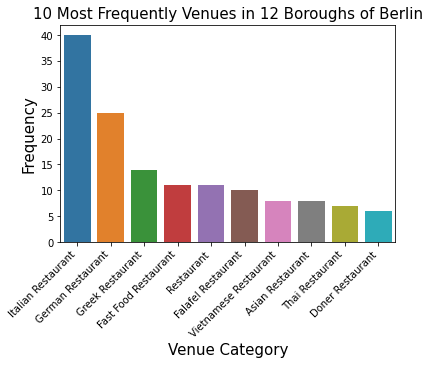

<Figure size 1296x1080 with 0 Axes>

In [23]:
import seaborn as sns
from matplotlib import pyplot as plt

s=sns.barplot(x="Venue_Category", y="Frequency", data=berlin_Venues_Top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Venues in 12 Boroughs of Berlin', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
fig = plt.figure(figsize=(18,15))
plt.show()

## 3.6 - Size of the dataframe that results.

In [24]:
print ("Shape with only Restaurant: ", berlin_Venues_only_restaurant.shape)
berlin_Venues_only_restaurant.head(10)

Shape with only Restaurant:  (214, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,Charlottenburg-Wilmersdorf,52.507856,13.263952,Rasas,52.512100,13.264464,Indian Restaurant
2,Charlottenburg-Wilmersdorf,52.507856,13.263952,Lindenwirtin,52.510335,13.271707,German Restaurant
3,Charlottenburg-Wilmersdorf,52.507856,13.263952,Piccolo Mondo,52.512355,13.267806,Italian Restaurant
4,Charlottenburg-Wilmersdorf,52.507856,13.263952,T.Viet,52.510178,13.282418,Vietnamese Restaurant
5,Charlottenburg-Wilmersdorf,52.507856,13.263952,China Restaurant Panda III,52.506494,13.280187,Asian Restaurant
6,Charlottenburg-Wilmersdorf,52.507856,13.263952,Engelbecken,52.508681,13.293996,German Restaurant
7,Charlottenburg-Wilmersdorf,52.507856,13.263952,Restaurant Mylos,52.506656,13.295862,Greek Restaurant
8,Charlottenburg-Wilmersdorf,52.507856,13.263952,La Victoria,52.510579,13.270550,Italian Restaurant
9,Charlottenburg-Wilmersdorf,52.507856,13.263952,Mateo-Looi Sushi Restaurant,52.511530,13.268428,Chinese Restaurant
10,Charlottenburg-Wilmersdorf,52.507856,13.263952,Kim's Ha,52.506770,13.296732,Vietnamese Restaurant


## 3.7 - Analysis of the neighbourhoods

In [25]:
berlin_Venues_restaurant = berlin_Venues_only_restaurant.groupby(['Neighborhood'])['Venue Category'].apply(lambda x: x[x.str.contains('Restaurant')].count())
berlin_Venues_restaurant

Neighborhood
Charlottenburg-Wilmersdorf    26
Friedrichshain-Kreuzberg      21
Lichtenberg Berlin            10
Marzahn-Hellersdorf           11
Mitte                          6
Neukölln                      21
Pankow                        12
Reinickendorf                 33
Spandau                       24
Steglitz-Zehlendorf           23
Tempelhof-Schöneberg          21
Treptow-Köpenick               6
Name: Venue Category, dtype: int64

In [26]:
berlin_Venues_restaurant_df  = berlin_Venues_restaurant.to_frame().reset_index()
berlin_Venues_restaurant_df.columns = ['Neighborhood', 'Number of Restaurant']
berlin_Venues_restaurant_df.index = np.arange(1, len(berlin_Venues_restaurant_df)+1)
list_rest_no =berlin_Venues_restaurant_df['Number of Restaurant'].to_list()
list_dist =berlin_Venues_restaurant_df['Neighborhood'].to_list()

In [27]:
# one hot encoding
berlin_onehot = pd.get_dummies(berlin_Venues_only_restaurant[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
berlin_onehot['Neighborhood'] = berlin_Venues_only_restaurant['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [berlin_onehot.columns[-1]] + list(berlin_onehot.columns[:-1])
berlin_onehot = berlin_onehot[fixed_columns]

berlin_onehot.head()

,Neighborhood,African Restaurant,Argentinian Restaurant,Asian Restaurant,Caucasian Restaurant,Chinese Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Charlottenburg-Wilmersdorf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,Charlottenburg-Wilmersdorf,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3.8 - Grouping by neighbourhoods and showing the mean of the frequency of occurrence for each category of restaurants.

In [28]:
berlin_grouped = berlin_onehot.groupby('Neighborhood').mean().reset_index()
berlin_grouped

,Neighborhood,African Restaurant,Argentinian Restaurant,Asian Restaurant,Caucasian Restaurant,Chinese Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,Falafel Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Syrian Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Charlottenburg-Wilmersdorf,0.000000,0.038462,0.076923,0.000000,0.038462,0.000000,0.000000,0.000000,0.038462,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.115385
1,Friedrichshain-Kreuzberg,0.047619,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.285714,...,0.000000,0.000000,0.000000,0.047619,0.000000,0.0,0.095238,0.000000,0.047619,0.000000
2,Lichtenberg Berlin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000000,0.200000
3,Marzahn-Hellersdorf,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090909,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,Mitte,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.000000,0.166667,0.000000,0.000000,0.0,0.000000,0.000000,0.166667,0.000000
5,Neukölln,0.095238,0.000000,0.000000,0.000000,0.000000,0.000000,0.095238,0.000000,0.095238,...,0.047619,0.095238,0.000000,0.095238,0.047619,0.0,0.000000,0.095238,0.095238,0.047619
6,Pankow,0.000000,0.000000,0.083333,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,...,0.000000,0.083333,0.000000,0.000000,0.000000,0.0,0.083333,0.000000,0.000000,0.000000
7,Reinickendorf,0.000000,0.060606,0.000000,0.000000,0.030303,0.000000,0.000000,0.060606,0.030303,...,0.000000,0.090909,0.060606,0.000000,0.030303,0.0,0.030303,0.000000,0.000000,0.000000
8,Spandau,0.000000,0.083333,0.000000,0.000000,0.041667,0.041667,0.000000,0.000000,0.000000,...,0.000000,0.083333,0.000000,0.000000,0.000000,0.0,0.000000,0.083333,0.000000,0.041667
9,Steglitz-Zehlendorf,0.000000,0.000000,0.086957,0.000000,0.000000,0.086957,0.000000,0.000000,0.000000,...,0.000000,0.043478,0.000000,0.000000,0.043478,0.0,0.043478,0.000000,0.000000,0.000000


In [29]:
berlin_grouped.shape

(12, 35)

## 3.9 - Print the neighbourhoods with their respective top 10 most common venues.

In [30]:
num_top_venues = 10

for nb in berlin_grouped['Neighborhood']:
    print("**** " + nb + " ****")
    temp = berlin_grouped[berlin_grouped['Neighborhood'] == nb].T.reset_index()
    temp.columns = ['venue','frequency']
    temp = temp.iloc[1:]
    temp['frequency'] = temp['frequency'].astype(float)
    temp = temp.round({'frequency': 2})
    print(temp.sort_values('frequency', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

**** Charlottenburg-Wilmersdorf ****
                      venue  frequency
0        Italian Restaurant       0.31
1         German Restaurant       0.19
2     Vietnamese Restaurant       0.12
3          Asian Restaurant       0.08
4          Greek Restaurant       0.04
5         Indian Restaurant       0.04
6  Mediterranean Restaurant       0.04
7        Falafel Restaurant       0.04
8    Argentinian Restaurant       0.04
9         French Restaurant       0.04


**** Friedrichshain-Kreuzberg ****
                       venue  frequency
0         Falafel Restaurant       0.29
1  Middle Eastern Restaurant       0.10
2            Thai Restaurant       0.10
3         African Restaurant       0.05
4   Mediterranean Restaurant       0.05
5        Lebanese Restaurant       0.05
6         Italian Restaurant       0.05
7         Spanish Restaurant       0.05
8          German Restaurant       0.05
9          French Restaurant       0.05


**** Lichtenberg Berlin ****
                       ven

## 3.10 - Creating a pandas dataframe.

In [31]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = berlin_grouped['Neighborhood']

for ind in np.arange(berlin_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(berlin_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(23)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Italian Restaurant,German Restaurant,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Argentinian Restaurant,French Restaurant
1,Friedrichshain-Kreuzberg,Falafel Restaurant,Middle Eastern Restaurant,Thai Restaurant,African Restaurant,Mediterranean Restaurant,Lebanese Restaurant,Italian Restaurant,Spanish Restaurant,German Restaurant,French Restaurant
2,Lichtenberg Berlin,Vietnamese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant,Syrian Restaurant,Indian Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant
3,Marzahn-Hellersdorf,Italian Restaurant,Fast Food Restaurant,Greek Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Thai Restaurant,Syrian Restaurant,Sushi Restaurant,Spanish Restaurant
4,Mitte,Seafood Restaurant,Vegetarian / Vegan Restaurant,Caucasian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant
5,Neukölln,African Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Spanish Restaurant,Restaurant,Korean Restaurant,Dumpling Restaurant,Vietnamese Restaurant,Sushi Restaurant
6,Pankow,Greek Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Doner Restaurant,Thai Restaurant,Mexican Restaurant,German Restaurant,African Restaurant
7,Reinickendorf,Italian Restaurant,German Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant,Greek Restaurant,Eastern European Restaurant,Argentinian Restaurant,Sushi Restaurant,New American Restaurant
8,Spandau,Italian Restaurant,German Restaurant,Fast Food Restaurant,Argentinian Restaurant,Turkish Restaurant,Restaurant,Vietnamese Restaurant,Halal Restaurant,Greek Restaurant,Mexican Restaurant
9,Steglitz-Zehlendorf,Italian Restaurant,German Restaurant,Asian Restaurant,Doner Restaurant,French Restaurant,Fast Food Restaurant,Restaurant,Greek Restaurant,Mexican Restaurant,Sushi Restaurant


## 3.11 - Clustering the neighbourhoods with k-means.

In [33]:
# set number of clusters
kclusters = 5

berlin_grouped_clustering = berlin_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(berlin_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 1, 4, 3, 2, 4, 1, 1, 1], dtype=int32)

In [34]:
berlin_merged = df
berlin_merged.head(10)

,Borough,Population,Area,Density,Latitude,Longitude
0,Charlottenburg-Wilmersdorf,"319,628",64.72,"4,878",52.507856,13.263952
1,Friedrichshain-Kreuzberg,"268,225",20.16,"13,187",52.501115,13.444285
2,Lichtenberg Berlin,"259,881",52.29,"4,952",52.532161,13.511893
3,Marzahn-Hellersdorf,"248,264",61.74,"4,046",52.522523,13.587663
4,Mitte,"332,919",39.47,"8,272",52.517885,13.404060
5,Neukölln,"310,283",44.93,"6,804",52.481150,13.435350
6,Pankow,"366,441",103.01,"3,476",52.597917,13.435316
7,Reinickendorf,"240,454",89.46,"2,712",52.604763,13.295287
8,Spandau,"223,962",91.91,"2,441",52.535788,13.197792
9,Steglitz-Zehlendorf,"293,989",102.50,"2,818",52.429205,13.229974


In [35]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Italian Restaurant,German Restaurant,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Argentinian Restaurant,French Restaurant
1,Friedrichshain-Kreuzberg,Falafel Restaurant,Middle Eastern Restaurant,Thai Restaurant,African Restaurant,Mediterranean Restaurant,Lebanese Restaurant,Italian Restaurant,Spanish Restaurant,German Restaurant,French Restaurant
2,Lichtenberg Berlin,Vietnamese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant,Syrian Restaurant,Indian Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant
3,Marzahn-Hellersdorf,Italian Restaurant,Fast Food Restaurant,Greek Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Thai Restaurant,Syrian Restaurant,Sushi Restaurant,Spanish Restaurant
4,Mitte,Seafood Restaurant,Vegetarian / Vegan Restaurant,Caucasian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant


In [36]:
neighborhoods_venues_sorted_w_clusters = neighborhoods_venues_sorted
neighborhoods_venues_sorted_w_clusters.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,Italian Restaurant,German Restaurant,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Argentinian Restaurant,French Restaurant
1,Friedrichshain-Kreuzberg,Falafel Restaurant,Middle Eastern Restaurant,Thai Restaurant,African Restaurant,Mediterranean Restaurant,Lebanese Restaurant,Italian Restaurant,Spanish Restaurant,German Restaurant,French Restaurant
2,Lichtenberg Berlin,Vietnamese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant,Syrian Restaurant,Indian Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant
3,Marzahn-Hellersdorf,Italian Restaurant,Fast Food Restaurant,Greek Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Thai Restaurant,Syrian Restaurant,Sushi Restaurant,Spanish Restaurant
4,Mitte,Seafood Restaurant,Vegetarian / Vegan Restaurant,Caucasian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant


In [37]:
# add clustering labels
neighborhoods_venues_sorted_w_clusters.insert(0, 'Nº Cluster', kmeans.labels_)
neighborhoods_venues_sorted_w_clusters.head()

,Nº Cluster,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Charlottenburg-Wilmersdorf,Italian Restaurant,German Restaurant,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Argentinian Restaurant,French Restaurant
1,2,Friedrichshain-Kreuzberg,Falafel Restaurant,Middle Eastern Restaurant,Thai Restaurant,African Restaurant,Mediterranean Restaurant,Lebanese Restaurant,Italian Restaurant,Spanish Restaurant,German Restaurant,French Restaurant
2,1,Lichtenberg Berlin,Vietnamese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant,Syrian Restaurant,Indian Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant
3,4,Marzahn-Hellersdorf,Italian Restaurant,Fast Food Restaurant,Greek Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Thai Restaurant,Syrian Restaurant,Sushi Restaurant,Spanish Restaurant
4,3,Mitte,Seafood Restaurant,Vegetarian / Vegan Restaurant,Caucasian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant


In [38]:
berlin_merged.rename(columns={'City district':'Neighborhood'}, inplace=True)

berlin_merged = berlin_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Borough')

berlin_merged.head()

,Borough,Population,Area,Density,Latitude,Longitude,Nº Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Charlottenburg-Wilmersdorf,"319,628",64.72,"4,878",52.507856,13.263952,1,Italian Restaurant,German Restaurant,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Argentinian Restaurant,French Restaurant
1,Friedrichshain-Kreuzberg,"268,225",20.16,"13,187",52.501115,13.444285,2,Falafel Restaurant,Middle Eastern Restaurant,Thai Restaurant,African Restaurant,Mediterranean Restaurant,Lebanese Restaurant,Italian Restaurant,Spanish Restaurant,German Restaurant,French Restaurant
2,Lichtenberg Berlin,"259,881",52.29,"4,952",52.532161,13.511893,1,Vietnamese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant,Syrian Restaurant,Indian Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant
3,Marzahn-Hellersdorf,"248,264",61.74,"4,046",52.522523,13.587663,4,Italian Restaurant,Fast Food Restaurant,Greek Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Thai Restaurant,Syrian Restaurant,Sushi Restaurant,Spanish Restaurant
4,Mitte,"332,919",39.47,"8,272",52.517885,13.404060,3,Seafood Restaurant,Vegetarian / Vegan Restaurant,Caucasian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant


### Finally, let's visualize the resulting clusters.

In [39]:
# create a map with folium
map_restaurants10 = folium.Map(location=[latitude,longitude], tiles='cartodbpositron', 
                               attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

# set color scheme for the five clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for lat, lon, poi, cluster in zip(berlin_merged['Latitude'], 
                                  berlin_merged['Longitude'], 
                                  berlin_merged['Borough'], 
                                  berlin_merged['Nº Cluster']):
    label = folium.Popup(str(poi) + ' Nº Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=list_rest_no[list_dist.index(poi)]*0.5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_restaurants10)
       
map_restaurants10

## 3.12 - Examination of the 5 clusters.

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

### Cluster 0

In [40]:
berlin_merged.loc[berlin_merged['Nº Cluster'] == 0, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,Population,Longitude,Nº Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,"241,335",13.600185,0,German Restaurant,Fast Food Restaurant,Sushi Restaurant,Greek Restaurant,Seafood Restaurant,Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant,Ramen Restaurant


* **Cluster 0** could be called the **German cluster**.

### Cluster 1

In [41]:
berlin_merged.loc[berlin_merged['Nº Cluster'] == 1, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,Population,Longitude,Nº Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"319,628",13.263952,1,Italian Restaurant,German Restaurant,Vietnamese Restaurant,Asian Restaurant,Greek Restaurant,Indian Restaurant,Mediterranean Restaurant,Falafel Restaurant,Argentinian Restaurant,French Restaurant
2,"259,881",13.511893,1,Vietnamese Restaurant,Italian Restaurant,Greek Restaurant,German Restaurant,Syrian Restaurant,Indian Restaurant,Ramen Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,New American Restaurant
7,"240,454",13.295287,1,Italian Restaurant,German Restaurant,Restaurant,Indian Restaurant,Seafood Restaurant,Greek Restaurant,Eastern European Restaurant,Argentinian Restaurant,Sushi Restaurant,New American Restaurant
8,"223,962",13.197792,1,Italian Restaurant,German Restaurant,Fast Food Restaurant,Argentinian Restaurant,Turkish Restaurant,Restaurant,Vietnamese Restaurant,Halal Restaurant,Greek Restaurant,Mexican Restaurant
9,"293,989",13.229974,1,Italian Restaurant,German Restaurant,Asian Restaurant,Doner Restaurant,French Restaurant,Fast Food Restaurant,Restaurant,Greek Restaurant,Mexican Restaurant,Sushi Restaurant


* **Cluster 1** could be called the **Italian cluster**.

### Cluster 2

In [42]:
berlin_merged.loc[berlin_merged['Nº Cluster'] == 2, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,Population,Longitude,Nº Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"268,225",13.444285,2,Falafel Restaurant,Middle Eastern Restaurant,Thai Restaurant,African Restaurant,Mediterranean Restaurant,Lebanese Restaurant,Italian Restaurant,Spanish Restaurant,German Restaurant,French Restaurant
5,"310,283",13.435350,2,African Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,Turkish Restaurant,Spanish Restaurant,Restaurant,Korean Restaurant,Dumpling Restaurant,Vietnamese Restaurant,Sushi Restaurant


* **Cluster 2** could be called the **Middle Eastern food and African cluster**.

### Cluster 3

In [43]:
berlin_merged.loc[berlin_merged['Nº Cluster'] == 3, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,Population,Longitude,Nº Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"332,919",13.40406,3,Seafood Restaurant,Vegetarian / Vegan Restaurant,Caucasian Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Restaurant,Mexican Restaurant,Moroccan Restaurant,New American Restaurant


* **Cluster 3** could be called the **Seafood cluster**.

### Cluster 4

In [44]:
berlin_merged.loc[berlin_merged['Nº Cluster'] == 4, berlin_merged.columns[[1] + list(range(5, berlin_merged.shape[1]))]]

,Population,Longitude,Nº Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"248,264",13.587663,4,Italian Restaurant,Fast Food Restaurant,Greek Restaurant,Restaurant,Mexican Restaurant,Asian Restaurant,Thai Restaurant,Syrian Restaurant,Sushi Restaurant,Spanish Restaurant
6,"366,441",13.435316,4,Greek Restaurant,Italian Restaurant,Restaurant,Asian Restaurant,Chinese Restaurant,Doner Restaurant,Thai Restaurant,Mexican Restaurant,German Restaurant,African Restaurant
10,"335,060",13.373703,4,Italian Restaurant,Asian Restaurant,Thai Restaurant,Chinese Restaurant,Doner Restaurant,Fast Food Restaurant,Korean Restaurant,Greek Restaurant,Restaurant,Middle Eastern Restaurant


* **Cluster 4** could be called the **Italian cluster**.